**July 2nd, 2013**

**@author C. M. Isborn, Noriyuki Tani**

### General

This script extracts data (coordinates, transition dipoles, excitation energies) from a CI (only CIS or CASSCF, currently) computation. Does not extract oscillator strengths yet. It uses the extracted data to calculate electronic dynamics using the TDCI method.

**NOTE**: The script assumes a square matrix made up of row-vectors of CI-coefficients for a CASSCF calculation, and a general rectangular matrix (# columns > # rows) one for a CIS calculation. - KR (06/13/2020)

### Applying EM pulse

The only kind of external field application implemented is the electric field under the dipole approximation. The application of the electric field is currently limited to a single pulse of a sinusoidal wave. The only kinds of pulse-envelope functions currently available are a smooth trapezoidal (the line-slopes of the trapzoid are replaced by two sigmoid functions), Gaussian and cosine.

(modified by B. Habenicht (`bfh`) and KR (`KR`) (b/w 2014 and 2020))

### Note: Running `TDCI_1pulse_latest.<ipynb/py>`

This script is meant to be run in the folder where the file `tdm_tdci.txt` is stored. This would typically mean that the script `calc_tdm_<cis/casscf>_latest.<ipynb/py>`, which produces `tdm_tdci.txt`, is also stored in the same folder, but this is not required.

In [1]:
%matplotlib inline

import sys                         # for interfacing with the shell
import numpy as np                 # for numerical work
import os                          # for interacting with the operating system
import shutil                      # for interfacing with the shell
import time                        # for timing loops/printing more readably
import matplotlib.pyplot as plt    # for plotting
from gauss_hf import *

**Defining conversion factors and parameters**

In [2]:
#====================
# CONVERSION FACTORS
#====================
# dipole moment: 1 debye = 0.393430307 a.u.
DtoAU = 0.39343
AUtoD = 1./DtoAU
# energy: 1 Ha = 27.211396 eV
#              = 219474.6305 /cm
#              = 6.579691506102500e15 Hz
HAtoEV = 27.211396
EVtoHA = 1./HAtoEV
HAtoHZ = 6.5796915061025e15
HZtoHA = 1./HAtoHZ
# time: 1 a.u. = 0.02418884254 fs
AUtoFS = 0.02418884
FStoAU = 1./AUtoFS
#===========
# CONSTANTS
#===========
# atomic {int(number): [str(symbol), float(mass)]} (up to 2nd row)
AtomicMass = {1: ['H', 1.0079], 2: ['He', 4.0026], 3: ['Li', 6.941], \
              4: ['Be', 9.0122], 5: ['B', 10.811], 6: ['C', 12.0107], \
              7: ['N', 14.0067], 8: ['O', 15.9994], 9: ['F', 18.9984], \
              10: ['Ne', 20.1797] \
             }

### Reading log-file

In [3]:
# this is the output file produced by "calc_tdm_mod-KR_<cis or casscf>_latest"
Logfile = 'tdm_tdci.txt'

# check whether "tdm_tdci.txt" exists
if os.path.isfile(Logfile) == True:
    print('file exists.')
elif os.path.isfile(Logfile) == False:
    print('error: file does not exist.')
    quit()

file exists.


In [4]:
data_file = log_data(logfile=Logfile, nonlog_error_msg=False)
log_lines = data_file.loglines


Reading data from tdm_tdci.txt...

Text file may not as expected (expecting Gaussian .LOG file):
  "n_a", "n_b", "nao" instance variables will NOT be available.
  Further, only "get_matrix_lowtri_AO()" and "get_ee_onee_AO()"
  methods may be accessible without errors. Use "help()" method
  to get more information about this module.



**Reading CI calculation parameters**

In [5]:
for (n,line) in enumerate(log_lines):
    try:
        if ('title' in line):
            # system name for output directory
            title = log_lines[n].split('=')[-1].strip()
        if ('method' in line):
            # CI method
            ci = log_lines[n].split('=')[-1].strip()
        if ('NMOLow' in line):
            # Lowest MO in the active space of CIS
            NMOLow = int(float(log_lines[n].split('=')[-1]))
        if ('NMOHigh' in line):
            # Highest MO in the active space of CIS
            NMOHigh = int(float(log_lines[n].split('=')[-1]))
        if ('NMOs' in line):
            # Total number of MOs, set to NCAS later
            NMOs = int(float(log_lines[n].split('=')[-1]))
        if ('NCAS' in line):
            # Number of MOs in the CI active space
            NCAS = int(float(log_lines[n].split('=')[-1]))
        if ('NFRZ' in line):
            # Number of MOs w/ frozen occupation
            NFRZ = int(float(log_lines[n].split('=')[-1]))
        if ('NOCC' in line):
            # Number of (doubly) occupied MOs
            NOCC = int(float(log_lines[n].split('=')[-1]))
        if ('NELECT' in line):
            # Number of electrons
            #   (= 2 x # alpha electrons for restricted reference)
            NELECT = int(float(log_lines[n].split('=')[-1]))
        if ('NAtoms' in line):
            # Number of atoms in the molecular system
            NAtoms = int(float(log_lines[n].split('=')[-1]))
        if ('NStates' in line):
            # Number of CI states (including the ground state)
            NStates = int(float(log_lines[n].split('=')[-1]))
    except (IndexError, ValueError):
        print('Error encountered while reading parameters.')
        print('Check the contents of "tdm_tdci.txt"')
        quit()
NMOs = NCAS        # Number of MOs in CAS
NSim = NStates     # Number of states in simulation (redundant at the moment)

# set dimensions of the CI matrices based on CI calculation-type
if (ci == 'casscf'):
    M = NStates
    N = NStates
elif (ci == 'cis'):
    M = NStates
    N = int((NOCC - NMOLow + 1)*(NMOHigh - NOCC)) + 1
else:
    print('requested method is not supported yet.')
    quit()

In [6]:
debug = 1
if debug == 1:
    print('method \t= "{}"'.format(ci))
    if (ci == 'cis'):
        print('NMOLow \t= {}'.format(NMOLow))
        print('NMOHigh = {}'.format(NMOHigh))
    print('NCAS \t= {}'.format(NCAS))
    print('NFRZ \t= {}'.format(NFRZ))
    print('NMOs \t= {}'.format(NMOs + NFRZ))
    print('NOCC \t= {}'.format(NOCC))
    print('NELECT \t= {}'.format(NELECT))
    print('NAtoms \t= {}'.format(NAtoms))
    print('NStates = {}'.format(NStates))
    print('NSim    = {}'.format(NSim))
debug = 0

method 	= "cis"
NMOLow 	= 1
NMOHigh = 6
NCAS 	= 6
NFRZ 	= 0
NMOs 	= 6
NOCC 	= 2
NELECT 	= 4
NAtoms 	= 2
NStates = 9
NSim    = 9


**Reading orientation of the molecule**

In [7]:
# Set up empty array for coordinates
AtNum = np.zeros([NAtoms], np.float64)
AtMass = np.zeros([NAtoms], np.float64)
CoordsX = np.zeros([NAtoms], np.float64)
CoordsY = np.zeros([NAtoms], np.float64)
CoordsZ = np.zeros([NAtoms], np.float64)
# Get coordinates 
for (n, line) in enumerate(log_lines):
    if ('Standard orientation:' in line): 
        for i in range(NAtoms):
            elements = log_lines[n+i+5].split()
            AtNum[i] = int(float(elements[1]))
            AtMass[i] = AtomicMass[AtNum[i]][1]
            CoordsX[i] = float(elements[3])
            CoordsY[i] = float(elements[4])
            CoordsZ[i] = float(elements[5])

**Reading nuclear dipole moments**

In [8]:
for (n, line) in enumerate(log_lines):
    if ('Nuclear dipole moments (a.u.)' in line):
        i = n + 2
        NucDipX = float(log_lines[i].split('=')[-1])
        NucDipY = float(log_lines[i+1].split('=')[-1])
        NucDipZ = float(log_lines[i+2].split('=')[-1])

In [9]:
debug = 1
if debug == 1:
    # print to screen
    print('Molecular geometry:')
    print(' Atom  \t    x \t    y \t    z')
    for i in range(NAtoms):
        AtSymbol = AtomicMass[AtNum[i]][0]
        print('  {}\t {: 4.3f}\t {: 4.3f}\t {: 4.3f}'\
              .format(AtSymbol, CoordsX[i], CoordsY[i], CoordsZ[i]))
    print('\nNuclear dipole moments (a.u.):')
    print(' nuc. dip. mom. (x) = {: 4.3f}'.format(NucDipX))
    print(' nuc. dip. mom. (y) = {: 4.3f}'.format(NucDipY))
    print(' nuc. dip. mom. (z) = {: 4.3f}'.format(NucDipZ))
debug = 0

Molecular geometry:
 Atom  	    x 	    y 	    z
  H	  0.000	  0.000	 -0.765
  Li	  0.000	  0.000	  0.765

Nuclear dipole moments (a.u.):
 nuc. dip. mom. (x) =  0.000
 nuc. dip. mom. (y) =  0.000
 nuc. dip. mom. (z) =  2.891


**Read Hartree-Fock SCF and CI energies** 

In [10]:
# Get SCF Energy
for (n, line) in enumerate(log_lines):
    if ('SCF Eone:' in line):
        elements = log_lines[n].split()
        ESCF = float(elements[4])
# Get CIS energy
CI_Energies = np.zeros([M], np.float64)
for (n,line) in enumerate(log_lines):
    if('Excited State ' in line):
        elements = log_lines[n].split()
        st = int(float(elements[2]))
        CI_Energies[st] = float(elements[3])*EVtoHA
CI_Energies[:] += ESCF

**Reading CI dipole moments**

In [11]:
CI_Dipoles = np.zeros((M, M), dtype='object')
linenum = []
for (n,line) in enumerate(log_lines):
    try:
        if ('CI state and transition dipole moments' in line):
            linenum.append(n)
    except (IndexError, ValueError):
        break
count = -1
n = linenum[count]
k = 2
while (k <= int(M**2 + 2)):
    try:
        elements = log_lines[n+k].split()
        st1 = int(float(elements[0]))
        st2 = int(float(elements[1]))
        dipvec = [float(elements[2]), float(elements[3]), float(elements[4])] 
        CI_Dipoles[st1,st2] = dipvec
        k += 1
    except (IndexError, ValueError):
        break

**Reading CI vectors**

In [12]:
CI_vect = np.zeros([M, N], np.float64)
linenum = []
for (n,line) in enumerate(log_lines):
    try:
        if ('Output CI Vectors' in line):
            linenum.append(n)
    except (IndexError, ValueError):
        break
n = linenum[-1]
k = 3
while (k <= (M + 3)):
    try:
        elements = log_lines[n+k].split()
        i = int(float(elements[0]))
        for j in range(N):
            CI_vect[i,j] = float(elements[j+1])
        k += 1
    except (IndexError, ValueError):
        break

**Reading CI configurations**

In [13]:
# get state-configuration info
config = np.zeros([M,NMOs], np.float64)
linenum = []
for (n,line) in enumerate(log_lines):
    if ('Orbital electron configuration' in line):
        linenum.append(n)
n = linenum[-1]
k = 3
while (k < (M + 3)):
    try:
        elements = log_lines[n+k].split()
        i = int(float(elements[0]))
        for j in range(NMOs):
            try:
                config[i,j] = float(elements[j+1])
            except (IndexError, ValueError):
                break
        k += 1
    except (IndexError, ValueError):
        break

In [14]:
debug = 0
if debug == 1:
    print('ESCF =',ESCF,' Ha\n')
    print('CI Excitation Energies (Ha)')
    print(CI_Energies[1:] - CI_Energies[0],'\n')
    print('CI Vectors')
    print(CI_vect,'\n')
    print('CI Electric Dipole Moments [x, y, z] (a.u.)')
    print(CI_Dipoles)
    print('CI congfigurations\n')
    print(config)
debug = 0

### Setting propagation and field parameters

In [15]:
# starting and targeted state-indices: chosen from the set of CI states (int)
st_ini = 0
st_trg = 1
# excitation energy (float)
deltaE = abs(CI_Energies[st_ini] - CI_Energies[st_trg])
# number of integration steps (int)
maxstep = 20000
# step-size (in au) (float)
delta = 0.083
# electric field amplitude (in au) (float)
emax = 0.5000
# frequency of field (in Ha) (float)
w = deltaE
# period of the field (in au) (int)
period_au = 2.*np.pi/w
# period of the field (in time-steps) (int)
period_tsteps = int(period_au/delta)
# cycles for which field is switched on (int)
ncyc = 1
# phase of electric field (float)
phase = 0.0
# step number to turn on field (int)
ton = int(0)
# duration for which the field is switched on (int)
duration = int(ncyc*period_tsteps + 1)
# step number to turn off field (int)
toff = ton + duration
# conversion factor for time-steps to fs (float)
steptofs = AUtoFS*delta
# using field-envelope for the field? (logical)
envelope_apply = False

**Setting up the pulse-envelope**

**NOTE**: Set `envelope_apply = True` above to apply the envelope. The envelope is currently only for one pulse.

In [16]:
if (envelope_apply == True):
    # the envelope shape ('trapezoidal', 'gaussian', 'cosine')
    envelope = 'trapezoidal'
    # split "duration" into cycles within the envelope
    cyc = 1    # can be "ncyc"
    # chirp (in au)
    chirp = 0.01
    # in case cyc is set to 1 or 0, to avoid breaking the code
    cyc += 2
    # scaled period in time-steps
    period_tsteps_scaled = int(duration/cyc)
    #
    # envelope = 'trapezoidal'
    #
    # exponent that determines sharpness of inflection (smooth trapezoid)
    decay = 0.05
    y= np.zeros((maxstep), np.float64)
    if(envelope == 'trapezoidal'):
        for t in range(ton,toff):
            if(t < toff):
                t_red_up = t-ton-period_tsteps_scaled/2
                t_red_down = t_red_up-(cyc-1)*period_tsteps_scaled
                if (t < ((cyc - 1)*period_tsteps_scaled + ton)):
                    if (t < (period_tsteps_scaled + ton)):
                        y[t] = 1/(1+np.exp(-decay*t_red_up))
                    else:
                        y[t] = 1/(1+np.exp(-decay*(period_tsteps_scaled/2)))
                else:
                    y[t] = 1-1/(1+np.exp(-decay*t_red_down))
            else:
                y[t] = 0
    #
    # envelope = 'gaussian'
    #
    elif(envelope == 'gaussian'):
        for t in range(ton,toff):
            if (t < toff):
                y[t] = np.exp(-16*np.log(2)*((toff - t)/duration-1/2)**2)
                y[t] -= 1/16
                y[t] /= 15/16
            else:
                y[t] = 0
    #
    # envelope = 'cosine'
    #
    elif(envelope == 'cosine'):
        for t in range(ton,toff):
            if (t < toff):
                y[t] = 0.5 - np.cos(2*(np.pi)*(toff - t)/duration)/2
            else:
                y[t] = 0

In [17]:
debug = 1
if debug == 1:
    print('Initial state    = {}'.format(st_ini))
    print('Target state     = {}'.format(st_trg))
    print('dt               = {:4.3f} au'.format(delta))
    print('Nt               = {} propagation steps'.format(maxstep))
    print('Field amplitude  = {:4.3f} au'.format(emax))
    print('Field frequency  = {:4.3f} au'.format(w))
    print('Field period     = {:4.3f} au'.format(period_au))
    print('                 = {} steps'.format(period_tsteps))
    print('Field cycles     = {}'.format(ncyc))
    print('Field phase      = {:4.3f} rads'.format(phase))
    print('Switch field on  at time-step {}'.format(ton))
    print('             off at time-step {}\n'.format(toff))
    print('\nIs the envelope being used? {}\n'.format(envelope_apply))
    if (envelope_apply == True):
        print('Pulse-envelope details:\n')
        print('Shape-'.format(envelope))
        # envelope print options
        if (envelope == 'trapezoidal'):
            print('{}-cycle {} pulse'.format(cyc,envelope))
            print(' (sigmoidal ramping)\n')
        elif (envelope == 'gaussian'):
            print('{}-cycle {} pulse;'.format(cyc,envelope))
            print(' (FWHM = {} cycle(s))\n'.format(int(cyc/2)))
        elif (envelope == 'cosine'):
            print('{}-cycle {} pulse\n'.format(cyc,envelope))
        else:
            print('Incompatible envelope option provided. Quitting...')
            quit()
        #
        print('Field-')
        if (abs(chirp) < 0.000001):
            print('Max. field str. = {:4.3f} au,'.format(emax))
            print(' freq. = {:4.3f} au\n'.format(w))
        else:
            print('Max. field str. = {:4.3f} au,'.format(emax))
            print('linear chirp frequencies:')
            print(' initial = {:4.3f} au,'.format(w-chirp))
            print(' final   = {:4.3f} au\n'.format(w+chirp))
        print('Plotting the envelope')
        t = range(maxstep)
        plt.plot(t[ton:toff],y[ton:toff])
        #plt.plot(t,y)
        plt.grid(True)
        plt.show()
debug = 0

Initial state    = 0
Target state     = 1
dt               = 0.083 au
Nt               = 20000 propagation steps
Field amplitude  = 0.500 au
Field frequency  = 0.168 au
Field period     = 37.320 au
                 = 449 steps
Field cycles     = 1
Field phase      = 0.000 rads
Switch field on  at time-step 0
             off at time-step 450


Is the envelope being used? False



**Setting up the field amplitude**

In [18]:
efield = np.zeros(maxstep)
if (envelope_apply == True):
    for t in range(ton,toff):
        # apply an envelope and a chirp-freq to the sinusoidal field
        w_chirp = w + chirp * (t/(ncyc*period_tsteps) - 0.5)
        efield[t] = emax * y[t] * (np.sin(w_chirp * delta * t + phase))
elif (envelope_apply == False):
    for t in range(ton,toff):
        # apply bare sinusoidal field
        efield[t] = emax * (np.sin(w * delta * t + phase))

Plotting the electric field


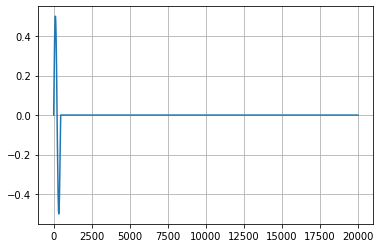

In [19]:
debug = 1
if debug == 1:
    print('Plotting the electric field')
    tpad = 0
    t = range(0,maxstep)
    #plt.plot(t[ton-tpad:toff+tpad],efield[ton-tpad:toff+tpad])
    plt.plot(t,efield)
    plt.grid(True)
    plt.show()
debug = 0

### Setting the orientation of field

**NOTE**: COMPARE WITH THE RT-TDDFT CALCULATION!! Field orientation needs to be the same for any meaningful comparison

In [20]:
# Direction for the field
x = 0.0     # +ve, -ve or 0.0
y = 0.0     # +ve, -ve or 0.0
z = 1.0     # +ve, -ve or 0.0
direction = [x,y,z]
norm_direc = direction/(np.linalg.norm(direction))   # normalization

## Time-propagation

The time-dependent Schrödinger equation (TDSE) is used to propagate the molecular system's wave-function, represented as a linear combination of its Hamiltonian's eigenstates, the CI states (matrices are in boldface font, vectors have an overhead arrow).

Let the system's wave-function be, in terms of the CI wave-functions, $\left\{ \Phi^\text{CI}_i \right\}$:

$$
 \Psi(\textbf{r},t) = \sum\limits_{i = 0}^{M} C_i (t) \cdot \Phi_i^\text{CI}(\textbf{r},t)
$$

In vector-form:

$$
 \vec{\Psi}(t) = \begin{bmatrix} C_0(t) \\ C_1(t) \\ \vdots \\ C_\text{st_ini}(t) \\ \vdots \\ C_\text{st_trg}(t) \\ \vdots \end{bmatrix}
$$

We *choose* to initiate the system's wave-function by completely occupying CI state with index `st_ini`.

$$
  \vec{\Psi}(0) = \begin{bmatrix} 0.0 \\ 0.0 \\ \vdots \\ 1.0 \\ \vdots \\ 0.0 \\ \vdots \end{bmatrix}
$$

The TDSE (for an un-normalized wave-function), combined with the dipole approximation for the time-dependent electric field, and in Hartree atomic units, is given by:

$$
 N(t) = \left( \vec{\Psi}^\dagger(t)\cdotp \vec{\Psi}(t) \right) \\
 \iota \times \frac{d}{dt}\vec{\Psi}(t) = \frac{\textbf{H}(t)}{N(t)}\cdotp \vec{\Psi}(t) \\
 = \frac{\left( \textbf{H}_0 + E(t;\omega_{\Delta E})\times \textbf{d}_0 \right)}{N(t)} \cdotp \vec{\Psi}(t)
$$

Here, $\omega_{\Delta E}$ is the frequency of the electric field corresponding to the difference in the energies of CI states (which are eigenstates of $\hat{H}_0$) `st_ini` and `st_trg` (this is also *by choice*). Henceforth, $E(t;\omega_{\Delta E}) \equiv E(t)$. For $dt \rightarrow 0$ (a very small time-step), the TDSE can be integrated numerically as follows:

$$
 \iota \Delta \vec{\Psi}(t) = \frac{\Delta t \left( \textbf{H}_0 + E(t) \textbf{d}_0 \right) }{N(t)} \cdotp \vec{\Psi}(t),
$$

and updating the wave-function vector at time $t$ is equivalent to the following:

$$
 \vec{\Psi}(t+1) = \left[ - \frac{\iota \Delta t (\textbf{H}_0 + E(t)\textbf{d}_0 )}{N(t)} + 1\right] \cdotp \vec{\Psi}(t)
$$

**Initialization of objects to be used for time-propagation**

In [21]:
# dipole moment
dip = np.zeros((maxstep), np.float64)
# vector of CI states that form the system's wave-function
v = np.zeros((maxstep, NSim), np.complex128)
# norm of system wave-function's CI-state vector
norm = np.zeros((maxstep), np.float64)
# (diagonal) Hamiltonian in the CI state basis (static in time)
h0 = np.diag(CI_Energies[:] - CI_Energies[0])
# dipole moment matrix in the CI state basis
d0 = np.zeros((NSim, NSim), np.float64)
for i in range(NSim):
    try:
        for j in range(NSim):
            d0[i,j] = np.dot(norm_direc, CI_Dipoles[i,j])
    except (TypeError, ValueError):
        print('Check the "CI_Dipoles" or "norm_direc" matrix!')
        print('(make sure they are filled with correct data.)')
        break
# complex arrays of CI state coefficients used for integration
ctmp = np.zeros((NSim), np.complex128)
# initial conditions
v[0,st_ini] = 1
norm[0] = np.sqrt(abs(np.dot(np.conjugate(v[0,:]), v[0,:])))
ctmp1 = v[0,:]
ctmp2 = ctmp1/norm[0]
dip[0] = np.real(np.dot(np.dot(np.conjugate(ctmp2), d0), ctmp2))

**Propagation**

In [22]:
for tstep in range(1,maxstep):
    # Leapfrog
    h = h0 + -1*efield[tstep]*d0
    comp_imag = np.dot(-1J*2*delta*h, ctmp2)
    ctmp = ctmp1 + comp_imag
    ctmp1 = list(ctmp2)
    norm[tstep] = np.sqrt(abs(np.dot(np.conjugate(ctmp), ctmp)))
    ctmp2 = ctmp/norm[tstep]
    v[tstep,:] = list(ctmp2)
    dip[tstep] = np.real(np.dot(np.dot(np.conjugate(ctmp), d0), ctmp2))

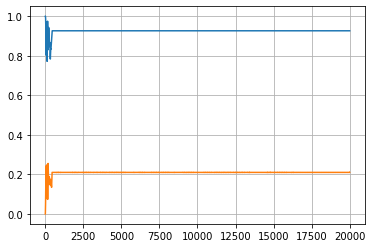

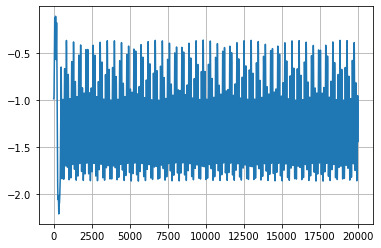

In [23]:
debug = 1
if debug == 1:
    # Plot two CI state coefficients vs time-steps
    istate1 = 0
    istate2 = 1
    x_i = range(maxstep)
    plt.plot(x_i,abs(v[:,istate1]),abs(v[:,istate2]))
    plt.grid(True)
    plt.show()
    # Plot instantaneous dipole moment vs time-steps
    plt.plot(t,dip)
    plt.grid(True)
    plt.show()
debug = 0

### Writing data to output files

In [24]:
std_prefix = 'td'+ ci   # TD method used
if (ci == 'casscf'):
    std_prefix += str(NELECT) + str(NCAS)   # TD method used
delimit = '_'    # delimiter for names of output files
std_ext = '.txt'    # output file extension
# define paths and create directories for saving output files
dir_parent = os.getcwd() + '/' # get the path of the current directory
dir_system = dir_parent + std_prefix + '_' + title + '/'
dir_data = dir_system + 'deltaE=' + str('{:2.2e}Ha'.format(w)) + delimit 
dir_data += 'emax=' + str(emax) + delimit
if (envelope_apply == True):
    dir_data += 'env=' + envelope + delimit
dir_data += 'time=' + str(ton) + 'to' + str(toff) + '/'
saveat = dir_data    # or './'
#''' Comment this line to delete and re-create directories
# create directories
dir_path = dir_data    # "dir_system" or "dir_data" or "dir_method"
try:
    print('making new directories for storing data...')
    os.makedirs(dir_path)
except (NotADirectoryError, FileExistsError):
    print('  detecting pre-existing directories...')
    if (os.path.isdir(dir_path) == True):
        shutil.rmtree(dir_path)
        print('  directories deleted.')
    time.sleep(5)    # wait for 5 seconds before making directories
    os.makedirs(dir_path)
    pass
if (os.path.isdir(dir_path) == True):
    print('data-directories created.')
#''' # Ignore this line if in notebook

making new directories for storing data...
  detecting pre-existing directories...
  directories deleted.
data-directories created.


**Instantaneous dipole moment** $\left( \vec{\Psi}(t)^\dagger \cdotp \textbf{d}_0 \cdotp \vec{\Psi}(t);\ \ \forall \ t \right)$

In [25]:
# output instanteous electric dipole moment
prop_file = 'dipole'
#name_file = std_prefix + delimit + transition + delimit + prop_file
name_file = prop_file
file = saveat + name_file + std_ext
idm = open(file, 'w')
prop_file = 'dipole2fft'
name_file = prop_file
file = saveat + name_file + std_ext
sdm = open(file, 'w')
dip *= AUtoD    # Dipole moment in debyes
for i in range(maxstep):
    t_fs = i*steptofs
    t_s = t_fs*1e-15
    idm.write('{:14.8f}\t{: 14.8f}\n'.format(t_fs, dip[i]))
    sdm.write('{:14.8e}\t{: 14.8f}\n'.format(t_s, dip[i]))
idm.close()
sdm.close()

**Time-dependent occupation numbers** (through projection of system's wave-function onto MOs)

In [26]:
# need to project state coefficients back onto MOs and print
prop_file = 'pops'
name_file = prop_file
file = saveat + name_file + std_ext
tcoef = open(file, 'w')
mo_coef = np.zeros([NMOs], np.float64)
for j in range(maxstep):
    t_fs = j*steptofs
    tcoef.write('{:16.8f}'.format(t_fs))
    for k in range(NMOs):
        mo_coef[k] = 0.0
        for n in range(NSim):
            tmp = np.conjugate(v[j,n])
            tmp2 = v[j,n]
            vcoef = tmp*tmp2
            vcoef = np.real(vcoef)
            mo_coef[k] += vcoef*config[n,k]
        tcoef.write('\t{:14.8f}'.format(mo_coef[k]))
    # total number of electrons at each time-step: a quality-check; should be constant.
    totN = np.sum(mo_coef)
    tcoef.write('\t\t{:4.4f}'.format(totN))
    tcoef.write('\n')
tcoef.close()

**Time-dependent system wave-function** (vector of squares of the norms of the time-dependent coefficients, $\left[ \left\{ C_i^*(t) C_i(t) \right\} \right]$)

In [27]:
prop_file = 'coefs'
name_file = prop_file
file = saveat + name_file + std_ext
bcoef = open(file, 'w')
for j in range(maxstep):
    t_fs = j*steptofs
    bcoef.write('{:16.8f}'.format(t_fs))
    for i in range(NSim):
        tmp = np.conjugate(v[j,i])
        tmp2 = v[j,i]
        vcoef = tmp*tmp2
        bcoef.write('\t\t{:16.8f}'.format(vcoef))
    bcoef.write('\n')
bcoef.close()

**Time-dependent electric field**

In [28]:
prop_file = 'field'
name_file = prop_file
file = saveat + name_file + std_ext
fldprt = open(file, 'w')
for i in range(maxstep):
    t_fs = i*steptofs
    fldprt.write('{:16.8f}\t\t{: 16.8f}\n'.format(t_fs, efield[i]))
fldprt.close()

**Time-dependent density matrix in AO basis**

In [29]:
location = './'
NAOs = NCAS + NFRZ
densTot = np.zeros([maxstep,NAOs,NAOs], np.complex128)
for i in range(NSim):
    for j in range(i,NSim):
        filename = location + 'dens_ci_'+str(i)+'_'+str(j)+'.npz'
        dens = np.load(filename, allow_pickle=True)
        densCI = dens['arr_0']
        for t in range(maxstep):
            if (i == j):
                densTot[t,:,:] += (abs(v[t,i])**2) * densCI
            else:
                # densCI is real, so transpose same as c.c.
                densTot[t,:,:] += v[t,i]*np.conjugate(v[t,j]) * densCI
                densTot[t,:,:] += v[t,j]*np.conjugate(v[t,i]) * densCI.T
save_file = saveat + 'td_dens_'+std_prefix+'_'+title+'.npz'
np.savez(save_file, td_dens_data=densTot)

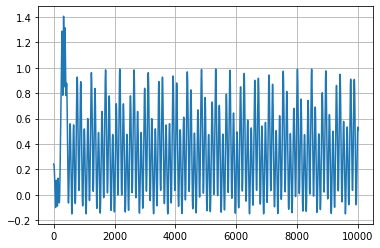

In [30]:
debug = 1
if debug == 1:
    # Plot density matrix elements vs time-steps
    row = 5
    col = 5
    x_i = range(maxstep)
    plt.plot(x_i[:10000],densTot[:10000,row,col])
    plt.grid(True)
    plt.show()
debug = 0